## Simulating Pressure and Volume using the Naghavi, et al., (2024) model

### Goals: Learn how to ...
- how do we define an instance of the model 
- what are the objects necessary to run a model 
- how to modify model parameters
- how to plot model outputs and compute basic stats using existing tools

From a high-level perspective **ModularCirc** is a repository of cardiovascular models. 
All predefined models are found within `ModularCirc.Models`.
Here we define two base clases, which serve as code templates for all specific implementations: 
1) `ModularCirc.Models.ParametersObject`
2) `ModularCirc.Models.OdeModel`

**They are not meant to be instantiated/run on their own.**



### 1. `ParametersObject`
A `ParametersObject` class serves as a counterpart of `OdeModel` and its purpose is to serve as an initial buffer:
1) It should store the default values for the system parameters (literature). Side effect: prevents forgetting to set parameter values.
2) It verifies whether the parameter exists within the predefined list of possibilities: prevents you from setting a paramter by mistake as a result of wrong model assumption/typo.

One example is `ModularCirc.Models.NaghaviModelParamters`. The model is derived from the following publication: 
- 2024 Naghavi et al., - Rapid estimation of left ventricular contractility with a physics-informed neural network inverse modeling approach.

Below, you can see the schematic depiction of the model:

<img src="Figures/Naghavi_model_schematic.png" alt="drawing" width="800"/>

In [1]:
from ModularCirc.Models.NaghaviModelParameters import NaghaviModelParameters

In [2]:
po = NaghaviModelParameters()

To see what are the default/current parameter values associated with the object one can simply use the `print` function:
```python
print(po)
```
This provides a list organised in terms of specific components associated with the model and possible parameter entry. 
Where a parameter value has not be defined it is marked as `nan`.

In [3]:
print(po)

Naghavi Model parameters set: 
 * Component - ao
  - r       : 2.400e+02
  - c       : 3.000e-01
  - l       : 0.000e+00
  - v_ref   : 1.000e+02
  - v       : 1.300e+02
  - p       : nan

 * Component - art
  - r       : 1.125e+03
  - c       : 3.000e+00
  - l       : 0.000e+00
  - v_ref   : 9.000e+02
  - v       : 1.092e+03
  - p       : nan

 * Component - ven
  - r       : 9.000e+00
  - c       : 1.333e+02
  - l       : 0.000e+00
  - v_ref   : 2.800e+03
  - v       : 3.780e+03
  - p       : nan

 * Component - av
  - r       : 6.000e+00
  - max_func : <function relu_max at 0x148871300>

 * Component - mv
  - r       : 4.100e+00
  - max_func : <function relu_max at 0x148871300>

 * Component - la
  - E_pas   : 4.400e-01
  - E_act   : 4.500e-01
  - v_ref   : 1.000e+01
  - k_pas   : 5.000e-02
  - activation_function : <function activation_function_1 at 0x1488719e0>
  - t_tr    : 2.250e+02
  - t_max   : 1.500e+02
  - tau     : 2.500e+01
  - delay   : 1.000e+02
  - v       : 9.360e+01
  

All this data is stored within the `components` atribute. 
Thus, if we want to see what are the componets associated with the model we can use:
```python
po.components.keys()
```

In [4]:
po.components.keys()

dict_keys(['ao', 'art', 'ven', 'av', 'mv', 'la', 'lv'])

If we want to see what are the parameters associated with a specific components we can use:

In [5]:
po.components['ao'].keys()

Index(['r', 'c', 'l', 'v_ref', 'v', 'p'], dtype='object')

if we want to see the parameter corresponding to the aorta. Alternatively, for the `lv`, we can use:

In [6]:
po.components['lv'].keys()

Index(['E_pas', 'E_act', 'v_ref', 'k_pas', 'activation_function', 't_tr',
       't_max', 'tau', 'delay', 'v', 'p', 'activation_func'],
      dtype='object')

Alterntively, one case also use:

In [7]:
po['lv'].keys()

Index(['E_pas', 'E_act', 'v_ref', 'k_pas', 'activation_function', 't_tr',
       't_max', 'tau', 'delay', 'v', 'p', 'activation_func'],
      dtype='object')

We can modify the value of a parameter directly (**not recommended** if code hasn't been tested beforehand):

In [8]:
# po['lv']['E_pas'] = 2.0

Alternatively you can modify the componet using a component specific method.

In [9]:
po.set_chamber_comp('lv', E_act=1)
po['lv']['E_act']

1

Using this approach we can avoid setting a parameter that doesn't exist.

In [10]:
# po.set_chamber_comp('lv', r=0.1)

### 2. Defining the instance of the model

In [11]:
from ModularCirc.Models.NaghaviModel import NaghaviModel

Before we instantiate the model, we need to define the details of the temporal discretization + other details. This is done using a dictionary. Here is an example:

In [12]:
TIME_SETUP_DICT = {
        'name'       :  'TimeTest', # the name asssociated with the temporal discretization (not super important.. names internal variable)
        'ncycles'    :  30,         # the maximum number of cycles for which we run the simulation
        'tcycle'     :  1000.,      # the duration of a heart beat (here in ms)
        'dt'         :  1.0,        # the duration of a discrete time step
        'export_min' :  3           # number of time steps for which we export the simulation (can also be used as a way to impose a minimum number of pulses)
    }

Now, instantiate the model, passing it the TIME_SETUP_DICT and the parameters object:

In [13]:
model = NaghaviModel(
    time_setup_dict=TIME_SETUP_DICT,
    suppress_printing=True,
    parobj=po,
    )

### 3. Defining a solver object 

In [14]:
from ModularCirc.Solver import Solver

Next we want to setup the solver. Here are some relevant parameters:
- `suppress_output`: if `False` we get a printout of the model components, their input/ouput state variables and constitutive functions
- `optimize_secondary_sv`: should be generally `False` (can expand on this for those curious)
- `step_tol`: the maximum step size allowable by the internal ODE solver
- `conv_cols`: specify the columns on which convergence (i.e. steady state) is tested on (format `p_` for pressure or `v_` for volume + component)

In [15]:
solver = Solver(model=model)
solver.setup(
    optimize_secondary_sv=False,
    suppress_output=True,
    step_tol=0.001,
    conv_cols=['p_lv', 'v_lv'],
    method='LSODA'
)

The `solver._asd` contains all state variable data for the solver. You can see it has one column for each state variable, and 30,000 rows since we are doing 30 cycels (heart beats) each last 1 second and we are using a 1ms resolution.

In [16]:
solver._asd

,v_ao,v_art,v_ven,v_la,v_lv,p_lv,q_av,p_ao,p_art,q_ao,p_ven,q_art,p_la,q_ven,q_mv
0,130.0,1092.0,3780.4,93.6,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
len(solver._global_psv_names)

10

Once the setup is done we can actually run the simulations using the `solve` method. 
We can verify if the solver converged using the `converged` atribute.

In [18]:
solver.solve()
# %prun -l 40 -s tottime solver.solve()
# %prun -l 40 -s cumtime solver.solve()
# %prun -s cumtime solver.solve()
solver.converged

True

We can also check the number of cycles necessary to reach steady state.

In [19]:
solver.Nconv

11

If we want to verify what are the values of the state variables we can use:

In [20]:
model.components['lv'].V

0        104.000000
1        108.909945
2        112.481850
3        115.092297
4        116.983035
            ...    
11996    102.896546
11997    102.939993
11998    102.978843
11999    103.013134
12000    103.042913
Name: v_lv, Length: 12001, dtype: float64

### Inspect outputs graphically

There is an option to also inspect the outputs graphically, using the `BaseAnalysis` class.

In [21]:
from ModularCirc.Analysis.BaseAnalysis import BaseAnalysis
import matplotlib.pyplot as plt

When creating the instance of the analysis object, we must provide the model as input.

In [22]:
ba = BaseAnalysis(model)

We can use it to quickly create plots to see if the the respective model makes sense. One useful method is `plot_p_v_loop` which can be used to plot the p-V loop of any component in the system by simply providing the name of that component:

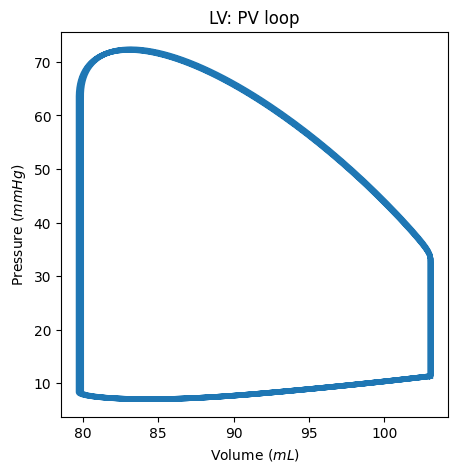

In [23]:
ba.plot_p_v_loop('lv')
plt.show()

If we are trying to create a more complex plot where we are looking at different components in each subplot, we can provide the axes as well.

[]

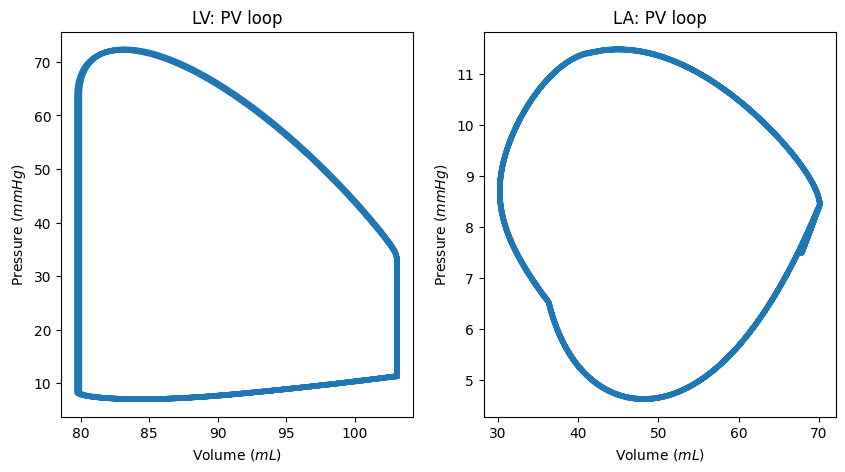

In [24]:
fig, ax= plt.subplots(ncols=2, figsize=(10, 5))
ba.plot_p_v_loop('lv', ax=ax[0])
ba.plot_p_v_loop('la', ax=ax[1])
plt.plot()

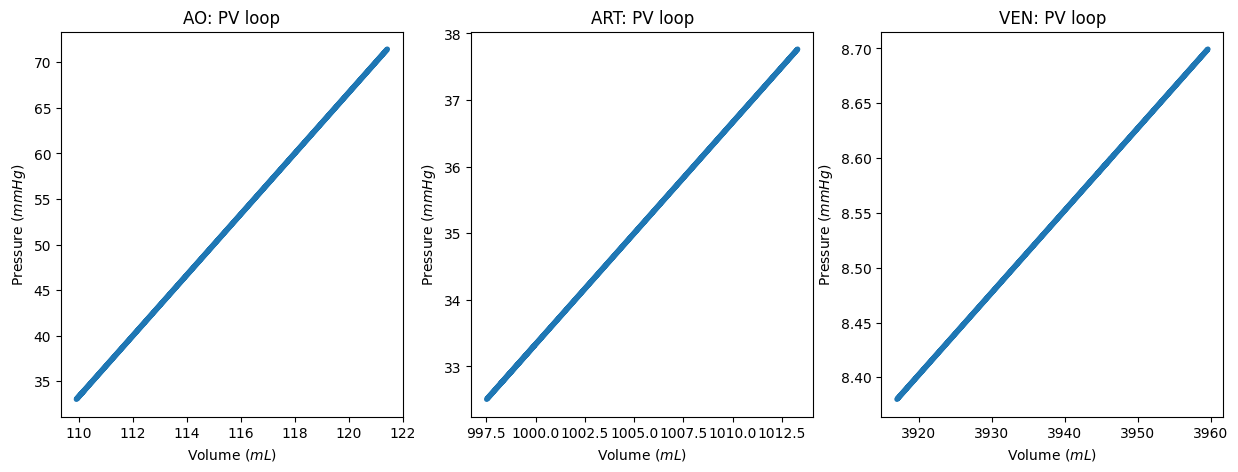

In [25]:
fig, ax= plt.subplots(ncols=3, figsize=(15, 5))
ba.plot_p_v_loop('ao', ax=ax[0])
ba.plot_p_v_loop('art', ax=ax[1])
ba.plot_p_v_loop('ven', ax=ax[2])

plt.show()

We can also use the ax input to overlay multiple traces for example if we want to see for example how pressure transients relate between the different components.

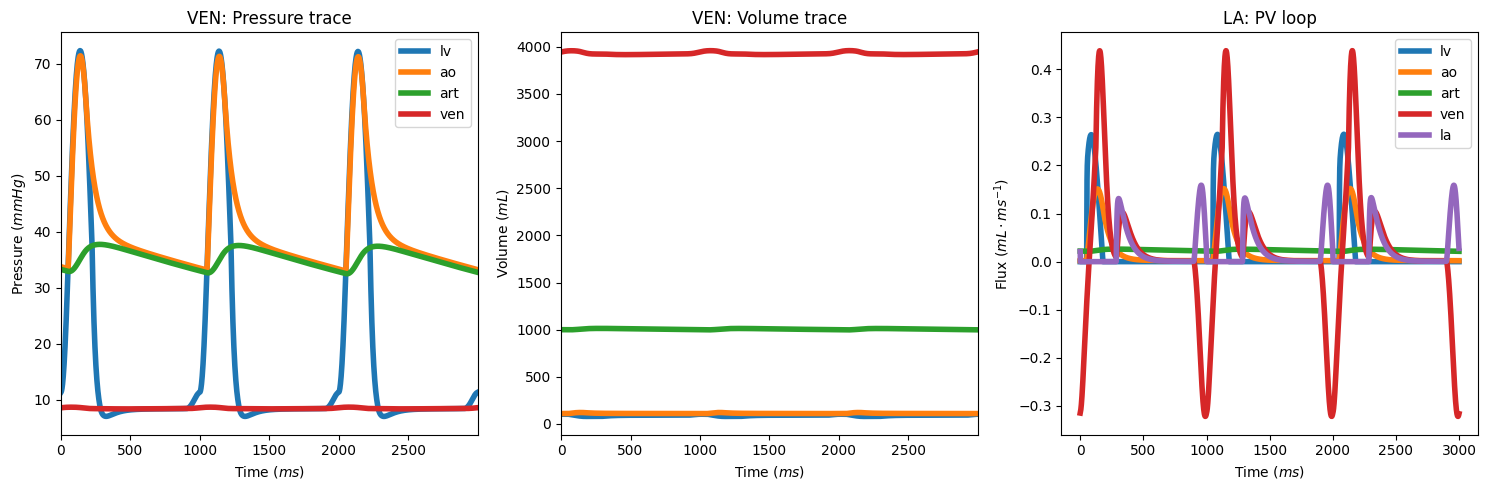

In [26]:
fig, ax= plt.subplots(ncols=3, figsize=(15, 5))
ba.plot_t_p('lv', ax=ax[0], time_units='ms')
ba.plot_t_p('ao', ax=ax[0], time_units='ms')
ba.plot_t_p('art', ax=ax[0], time_units='ms')
ba.plot_t_p('ven', ax=ax[0], time_units='ms')

ba.plot_t_v('lv', ax=ax[1], time_units='ms')
ba.plot_t_v('ao', ax=ax[1], time_units='ms')
ba.plot_t_v('art', ax=ax[1], time_units='ms')
ba.plot_t_v('ven', ax=ax[1], time_units='ms')

ba.plot_t_q_out('lv', ax=ax[2], time_units='ms')
ba.plot_t_q_out('ao', ax=ax[2], time_units='ms')
ba.plot_t_q_out('art', ax=ax[2], time_units='ms')
ba.plot_t_q_out('ven', ax=ax[2], time_units='ms')
ba.plot_t_q_out('la', ax=ax[2], time_units='ms')

ax[0].legend()
ax[2].legend()

fig.tight_layout()
plt.show()

We can use `ba` to estimate the cardiac output predicted by the model.

In [27]:
print(ba.compute_cardiac_output('lv'))

1.3963757724510153


We can also use it to predict the minimum and maximum pressure reached by a given component.

In [28]:
ba.compute_artery_pressure_range('ao')

(np.float64(33.01671614474511), np.float64(71.43561777176953))